# Fast Gradient Sign Method

## Train Threat Model

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [48]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=True, num_workers=2)

device = torch.device('mps' if torch.backends.mps.is_available else 'cpu')
device

device(type='mps')

In [7]:
class FMnistCls(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, 3)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(8 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(-1, 8 * 8 * 8)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
model = FMnistCls().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    scheduler.step()
    
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(trainset)
    epoch_acc = running_corrects.float() / len(trainset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

Epoch 1/10, Loss: 0.8858, Acc: 0.6653
Epoch 2/10, Loss: 0.4679, Acc: 0.8264
Epoch 3/10, Loss: 0.4040, Acc: 0.8529
Epoch 4/10, Loss: 0.3660, Acc: 0.8661
Epoch 5/10, Loss: 0.3136, Acc: 0.8848
Epoch 6/10, Loss: 0.3041, Acc: 0.8878
Epoch 7/10, Loss: 0.2989, Acc: 0.8888
Epoch 8/10, Loss: 0.2945, Acc: 0.8907
Epoch 9/10, Loss: 0.2919, Acc: 0.8910
Epoch 10/10, Loss: 0.2883, Acc: 0.8928


In [63]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

def visualize(model, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    cnt = 0
    plt.figure(figsize=(8,10))
    
    for i in range(4):
        for j in range(4):
            cnt += 1
            plt.subplot(4, 4, cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            img = inputs[cnt-1].squeeze().cpu().numpy()
            pred = predicted[cnt-1].item()
            plt.title(f"{labels_map[pred]}")
            plt.imshow(img, cmap='gray')
    plt.show()
    print(f"acc = {acc:.4f}%")

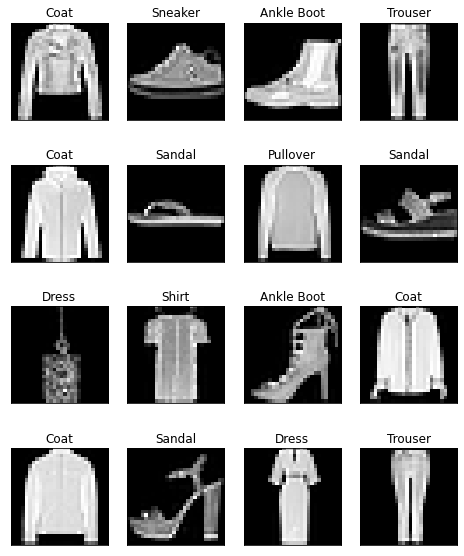

acc = 89.4900%


In [64]:
visualize(model, device)

## Implement FGSM

In [73]:
assert model.training == False

epsilons = [0, .05, .1, .15, .2, .25, .3]

test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

In [84]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return perturbed_image

def test(model, device, test_loader, epsilon):

    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)
        data.requires_grad = True

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue
        
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target)
        
        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        output = model(perturbed_data)

        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1

            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:

            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )


    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))


    return final_acc, adv_examples

In [85]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8949 / 10000 = 0.8949
Epsilon: 0.05	Test Accuracy = 5475 / 10000 = 0.5475
Epsilon: 0.1	Test Accuracy = 2767 / 10000 = 0.2767
Epsilon: 0.15	Test Accuracy = 1400 / 10000 = 0.14
Epsilon: 0.2	Test Accuracy = 668 / 10000 = 0.0668
Epsilon: 0.25	Test Accuracy = 266 / 10000 = 0.0266
Epsilon: 0.3	Test Accuracy = 117 / 10000 = 0.0117


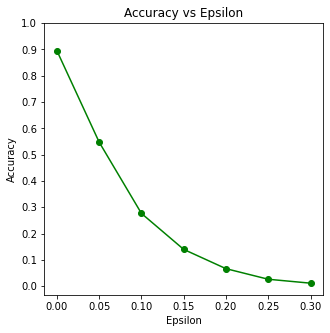

In [86]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "o-", c='g')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

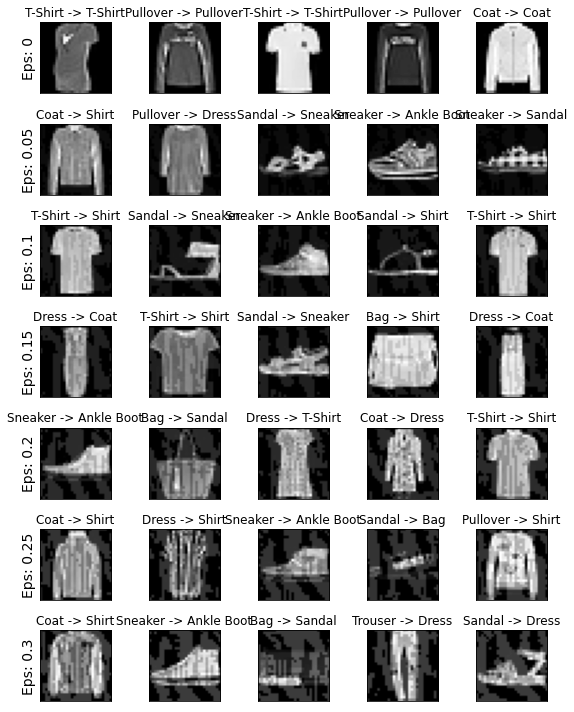

In [87]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(labels_map[orig], labels_map[adv]))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()